# Classification

### Use a decision tree to learn a classification model that predicts the number of persons that used a bicycle (column “cnt”) based on the available features. 

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn import model_selection, preprocessing
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

In [20]:
df = pd.read_csv('./day.csv', sep=",", quoting=3)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [21]:
df = df.astype(str)
df['cnt'] = pd.to_numeric(df['cnt'])

### See the distribution of the numeric data in cnt column

The data is imbalanced. The group 4000-6000 is the majority class, while the target class 1-2000 is the minority class(with the less samples).

Cnt target class
count     731.000000
mean     4504.348837
std      1937.211452
min        22.000000
25%      3152.000000
50%      4548.000000
75%      5956.000000
max      8714.000000
Name: cnt, dtype: float64


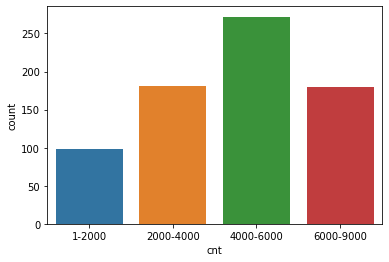

In [22]:
print('Cnt target class')
print(df['cnt'].describe())
# Create 4 categories of the target column cnt:
# 22-2000, 2000-4000, 4000-6000, 6000-9000
bins = [1,2000,4000,6000,9000]
df_cnt=pd.cut(df['cnt'], bins=bins, labels=['1-2000', '2000-4000', '4000-6000', '6000-9000'])

# Plot data distribution
sns.countplot(df_cnt)

When a Decision Tree classifier model was trained on the imbalanced dataset and applied to the test set, the accuracy obtained was 94%. But the precision and recall scores for the minority class was 0%

In [31]:
df['dteday'] = pd.to_datetime(df["dteday"]).astype(np.int64)
X = df.drop(columns=['instant','cnt'])
y = preprocessing.LabelEncoder().fit_transform(list(df_cnt.values))


clf = DecisionTreeClassifier(criterion = 'entropy')
clf.fit(X, y)

kf = StratifiedKFold(n_splits=10, shuffle=True)
y_pred = cross_val_predict(clf, X, y, cv=kf)

print('Evaluating the results of the predictions given the training data:\n')
# Print the overall accuracy, as well as the f1, precision and recall for each class
classification_report = metrics.classification_report(y, y_pred, target_names= np.unique(list(df_cnt.values)))
print(metrics.classification_report(y, y_pred, digits=3))

Evaluating the results of the predictions given the training data:

              precision    recall  f1-score   support

           0      0.922     0.959     0.940        98
           1      0.943     0.906     0.924       181
           2      0.942     0.960     0.951       272
           3      0.972     0.961     0.966       180

    accuracy                          0.947       731
   macro avg      0.945     0.946     0.945       731
weighted avg      0.947     0.947     0.947       731



In [24]:
# Using stratified sampling instead of random train test split
random_seed = 7
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=random_seed, stratify=y)

### Improve the performance

Balance the dataset, using the SMOTE oversampling method, with class ratio of 1. 

Then perform 10-fold cross-validation on the balanced training set in order to get an estimate of test set performance.

In [25]:
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

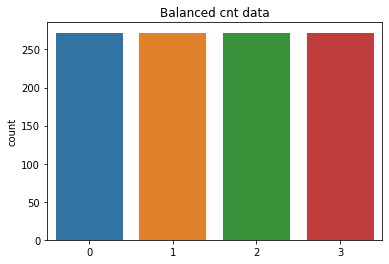

In [26]:
sns.countplot(y)
plt.title('Balanced cnt data')
plt.show()

In [34]:
seed = 7
num_trees = 30
kfold = model_selection.KFold(n_splits=10, random_state=seed)
classifier = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)

classifier.fit(X, y)

y_pred = model_selection.cross_val_predict(classifier, X, y, cv=kfold)

print('After the resampling, evaluate the results of the predictions given the training data:\n')
classification_report = metrics.classification_report(y, y_pred, target_names=np.unique(list(df_cnt.values)))
print(classification_report)

/home/maria/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


After the resampling, evaluate the results of the predictions given the training data:

              precision    recall  f1-score   support

      1-2000       1.00      0.05      0.10        98
   2000-4000       0.31      0.36      0.34       181
   4000-6000       0.45      0.77      0.57       272
   6000-9000       0.75      0.23      0.36       180

    accuracy                           0.44       731
   macro avg       0.63      0.35      0.34       731
weighted avg       0.56      0.44      0.40       731



### Ensuring that overfitting has not occurred, use the learned model to identify the two most prominent features.

The evaluation on the test data give same results with the evaluation on the training data. That means that the learned model did not overfit.

In [35]:
# Evaluate on test data
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
metrics.classification_report(y_test, y_pred, target_names=np.unique(list(df_cnt.values)))
print('Evaluate the results of the predictions given the training data:\n')
print(classification_report)

Evaluate the results of the predictions given the training data:

              precision    recall  f1-score   support

      1-2000       1.00      0.05      0.10        98
   2000-4000       0.31      0.36      0.34       181
   4000-6000       0.45      0.77      0.57       272
   6000-9000       0.75      0.23      0.36       180

    accuracy                           0.44       731
   macro avg       0.63      0.35      0.34       731
weighted avg       0.56      0.44      0.40       731



/home/maria/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
# zip and sort the feature_importances_ in desc order
# print the two most prominent features, based on the feature_importances_
feature_importances=zip(X.columns, classifier.feature_importances_)
feature_importances=sorted(feature_importances, key=lambda x: x[1], reverse = True)
important_features=feature_importances[:2]
print('The two most prominent features are:\n',important_features)

The two most prominent features are:
 [('registered', 0.5666666666666667), ('casual', 0.43333333333333335)]
